In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
import pylab
from scipy.fftpack import rfft, irfft, fftfreq

%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 6)

In [2]:
%%capture
%load_ext sql

address = '127.0.0.1'
user = 'myadmin'
database = 'csciApp.db'

%sql sqlite:///$database

u'Connected: None@csciApp.db'

In [132]:
motionDevReset = """
DROP TABLE IF EXISTS MotionData_dev;
CREATE TABLE MotionData_dev (id INTEGER PRIMARY KEY AUTOINCREMENT, 
                             xAxis REAL, 
                             yAxis REAL, 
                             zAxis REAL,
                             timeStep REAL);
"""

tempReset = """
DROP TABLE IF EXISTS MotionData_temp;
CREATE TABLE MotionData_temp (xAxis REAL,yAxis REAL,zAxis REAL,timeStep REAL);
INSERT INTO MotionData_temp SELECT xAxis,yAxis,zAxis,timeStep FROM MotionData_dev;
"""

In [135]:
%sql $motionDevReset

Done.
Done.


[]

In [ ]:
def blur(array,wsize):
    arr = np.array(array).copy()
    return arr[:len(arr)/wsize*wsize].reshape(-1,wsize).mean(1) 

def filter_signal(sig,dt):
    signal = sig.copy()
    N = len(signal)
    W = fftfreq(N, dt)
    
    f_signal = rfft(signal)
    #f_signal=f_signal*conj(f_signal)/N
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<10)] = 0
    #cut_f_signal[(W>30)] = 0
    freq = W[np.argmax(np.abs(cut_f_signal))]
    print "Detected Frequency: {0} Hz".format(freq)
    
    cut_signal = irfft(cut_f_signal)
    
    plt.subplot(221)
    plt.plot(range(0,len(signal)),signal)
    plt.subplot(222)
    plt.plot(W,f_signal)
    plt.subplot(223)
    plt.plot(W,cut_f_signal)
    plt.subplot(224)
    plt.plot(range(0,len(cut_signal)),cut_signal)
    plt.show()
    
    return cut_signal

In [305]:
threshTop = 0.45
threshBot = -0.45
def findHeartRate(df,dt):
    v = df["zAxis"].values
    N = len(v) 
    print "Sampling Frequency: {0} Hz, {1} seconds".format(1/dt,dt*N)
    
    dv = np.gradient(v)
    dv[dv>0.030] = 0.03
    dv[dv<-0.030] = -0.03
    norm = np.array([float(d)/max(dv) for d in dv])
    
    pulses = norm.copy()
    pulses[pulses<threshBot] = -1
    pulses[pulses>threshTop] = 1
    pulses[abs(pulses)!=1] = 0
    
    top = np.where(pulses==1)[0]
    bottom = np.where(pulses==-1)[0]
    top = np.unique(np.array([int(t/14.0) for t in top]))
    bottom = np.unique(np.array([int(b/14.0) for b in bottom]))
    
    beatcount=len(np.intersect1d(top,bottom))
    topcnt = len(top)
    bottomcount = len(bottom)
    
    print "{0} Top BPM".format(topcnt*60/(dt*N))
    print "{0} Bottom BPM".format(bottomcount*60/(dt*N))
    print "{0} Both BPM".format(beatcount*60.0/(dt*N))

    plt.subplot(221)
    plt.plot(range(0,len(v)),v)
    plt.subplot(222)
    plt.plot(range(0,len(dv)),dv)
    plt.subplot(223)
    plt.plot(range(0,len(norm)),norm)
    plt.subplot(224)
    plt.plot(range(0,len(pulses)),pulses)
    plt.show()

In [306]:
%sql $tempReset

Done.
Done.
4123 rows affected.


[]

Done.
Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
78.1231361073 Top BPM
114.179968157 Bottom BPM
78.1231361073 Both BPM


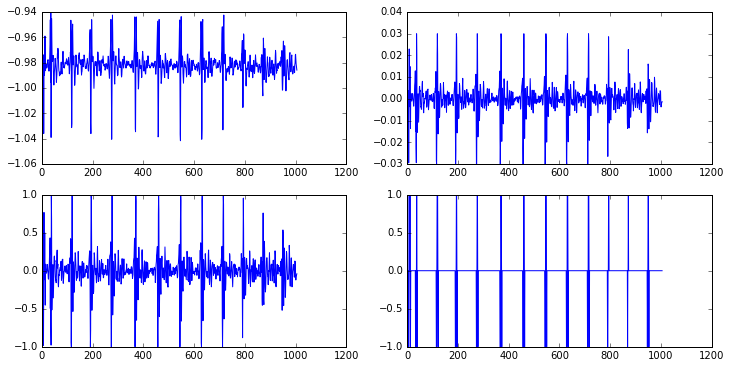

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
78.1231361073 Top BPM
102.16102414 Bottom BPM
78.1231361073 Both BPM


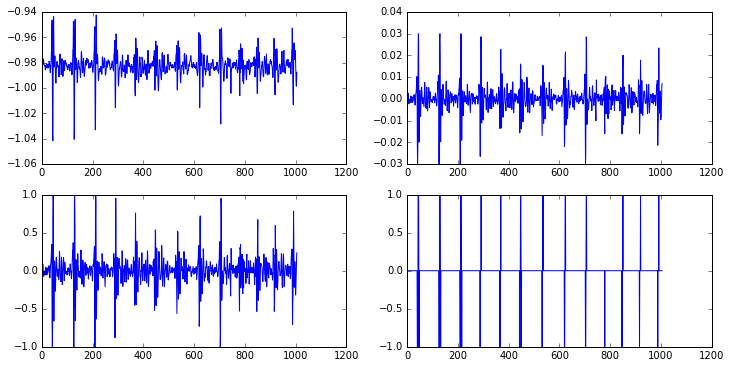

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
72.113664099 Top BPM
84.1326081155 Bottom BPM
66.1041920908 Both BPM


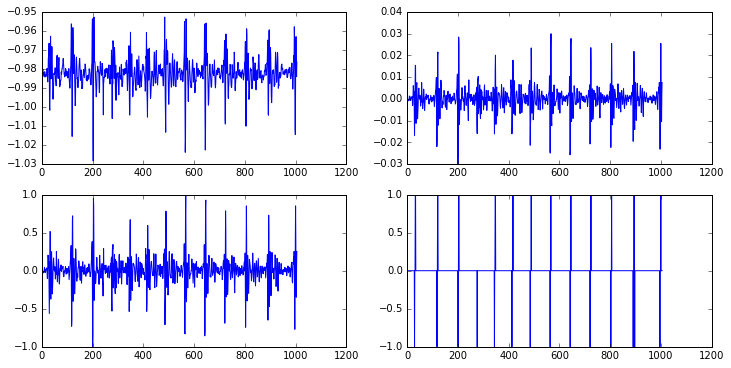

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
78.1231361073 Top BPM
84.1326081155 Bottom BPM
78.1231361073 Both BPM


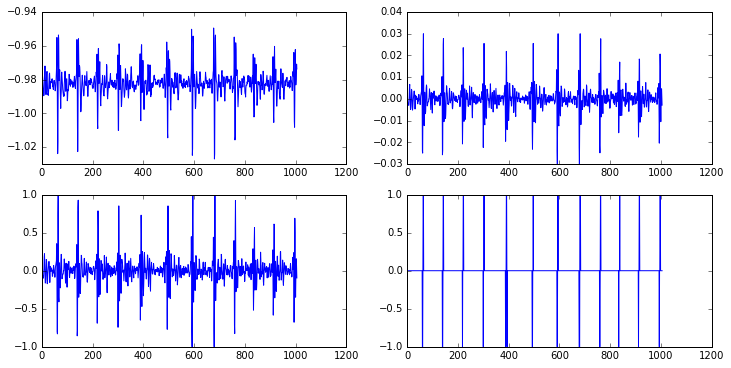

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
72.113664099 Top BPM
72.113664099 Bottom BPM
60.0947200825 Both BPM


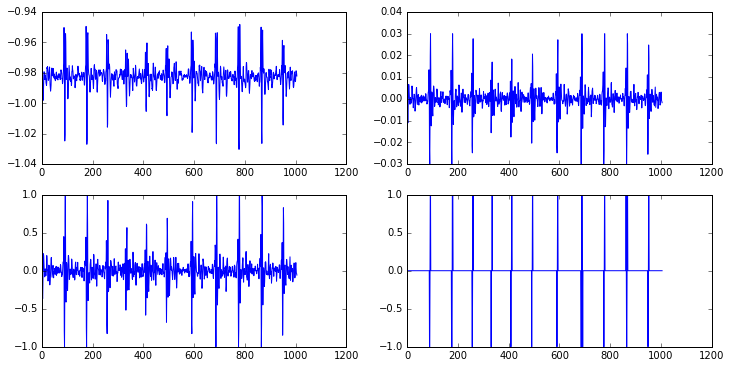

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
72.113664099 Top BPM
66.1041920908 Bottom BPM
36.0568320495 Both BPM


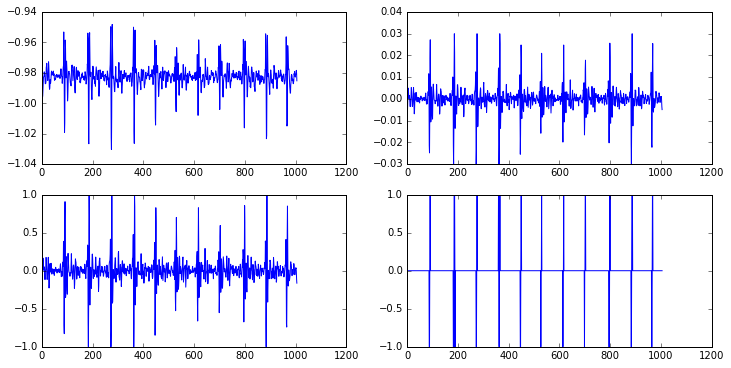

Sampling Frequency: 100.758814005 Hz, 9.98423820223 seconds
72.113664099 Top BPM
78.1231361073 Bottom BPM
42.0663040578 Both BPM


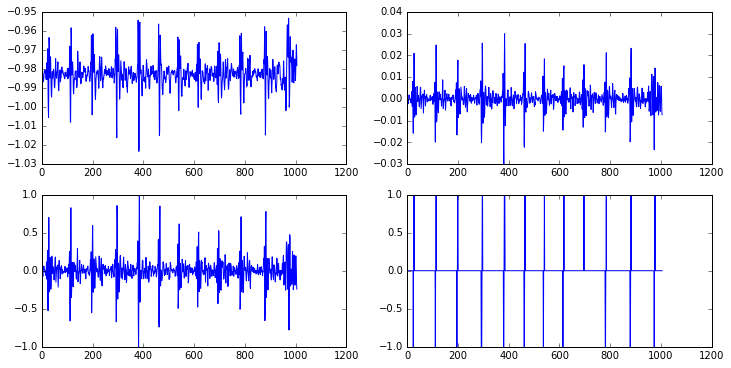

In [309]:
### load data
results = %sql select * from MotionData_temp
df = results.DataFrame()

### set time window
dt = df["timeStep"].mean()/1000.0
time = int(5.0/dt) ## 10 seconds
end = 2*time
start = 0
while end < df.shape[0]:
    #print "df[{0}:{1}]".format(start,end)
    findHeartRate(df[start:end],dt)
    start=end-time
    end+=time